# Load Data

In [461]:
import kagglehub
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE, ADASYN, SVMSMOTE
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

In [462]:
path = kagglehub.dataset_download("yashpaloswal/fraud-detection-credit-card")
print("Path to dataset files:", path)

for filename in os.listdir(path):
    if filename.endswith(".csv"):
        filepath = os.path.join(path, filename)
        try:
            df = pd.read_csv(filepath)
            print(f"Successfully loaded {filename} into a DataFrame.")
            break
        except pd.errors.ParserError:
            print(f"Error parsing {filename}. Skipping this file.")
        except Exception as e:
            print(f"An error occurred while loading {filename}: {e}")

df_backup = df.copy()

Path to dataset files: /kaggle/input/fraud-detection-credit-card
Successfully loaded creditcard.csv into a DataFrame.


# Helper Functions

In [463]:
# Function for temporal train-test split

def temporal_split(df):
  split_time = df['Time'].quantile(0.8)
  train_df = df[df['Time'] <= split_time]
  test_df = df[df['Time'] > split_time]
  X_train = train_df.drop(columns=['class'])
  y_train = train_df['class']
  X_test = test_df.drop(columns=['class'])
  y_test = test_df['class']
  return X_train, y_train, X_test, y_test

In [464]:
# Splits dataset into folds

def split_into_folds(df, num_folds):
    fold_size = len(df) // num_folds
    folds = []
    for fold in range(num_folds):
        start = fold * fold_size
        if(fold == num_folds - 1):
            end = len(df)
        else:
            end = (fold + 1) * fold_size
        fold_df = df.iloc[start:end]
        folds.append(fold_df)
    return folds

In [465]:
# Function used to train/evaluate a model using the temporal split


def run_temporal(df, model):

    print(f"\n Model: {model.__class__.__name__}")
    X_train, y_train, X_test, y_test = temporal_split(df)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fraud", "Fraud"])
    cm_display.plot(cmap='Blues')
    plt.title(f"Confusion Matrix for {model.__class__.__name__}")
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    else:
        y_scores = model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_scores)
    auc = roc_auc_score(y_test, y_scores)

    plt.figure()
    plt.plot(fpr, tpr, label=f'{model.__class__.__name__} (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model.__class__.__name__}')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()


In [466]:
# Function to perform Stratified K Fold and train/evaluate model

def run_temporal_kfold(df, model):

  print(f"\nModel: {model.__class__.__name__}")
  num_splits = 5
  tests = []
  predictions = []
  probabilities = []

  df = df.sort_values('Time').reset_index(drop=True)
  folds = split_into_folds(df, num_splits)

  for index, fold in enumerate(folds):

    X_train, y_train, X_test, y_test = temporal_split(fold)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    predictions.extend(y_pred)
    probabilities.extend(y_prob)
    tests.extend(y_test)

    # Confusion Matrix and Classification report
    print(f"\n\nClasses in Fold {index}: {y_test.value_counts().to_dict()}\n")
    print(f"Classification Report for Fold - {index}")
    print(classification_report(y_test, y_pred))


  # Showing final results across all folds
  final_auc = roc_auc_score(tests, probabilities)
  fpr, tpr, _ = roc_curve(tests, probabilities)
  plt.figure()
  plt.plot(fpr, tpr, label=f'Final ROC (AUC = {final_auc:.2f})', color='blue')
  plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Final ROC Curve - {model.__class__.__name__} (All Folds)')
  plt.legend(loc='lower right')
  plt.grid()
  plt.show()

  cm = confusion_matrix(tests, predictions)
  cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fraud", "Fraud"])
  cm_display.plot(cmap='Blues')
  plt.title(f"Final Confusion Matrix for {model.__class__.__name__} (all folds)")
  plt.show()

  print(f"\n\nFinal Classification Report")
  print(classification_report(tests, predictions))

In [467]:
# Function to show lag features

def plot_acf_pacf_all(df, lags=40, exclude_cols=['Time', 'class']):
    features = [col for col in df.columns if col not in exclude_cols]

    for col in features:
        fig, axes = plt.subplots(1, 2, figsize=(14, 4))
        fig.suptitle(f'ACF and PACF for {col}', fontsize=16)

        plot_acf(df[col], lags=lags, ax=axes[0])
        plot_pacf(df[col], lags=lags, ax=axes[1], method='ywm')

        axes[0].set_title(f'{col} - ACF')
        axes[1].set_title(f'{col} - PACF')
        plt.tight_layout()
        plt.show()

In [468]:
def add_lag_features(df, lag_config, y_col='class', substitute_value=-999):

    df_copy = df.copy()

    #Create lag features
    for col, num_lags in lag_config.items():
        for lag in range(1, num_lags + 1):
            df_copy[f"{col}_lag{lag}"] = df_copy[col].shift(lag)

    #Identify all lag columns
    lag_cols = [f"{col}_lag{lag}" for col, n in lag_config.items() for lag in range(1, n + 1)]

    #Split into positive and negative classes
    positives = df_copy[df_copy[y_col] == 1].copy()
    negatives = df_copy[df_copy[y_col] == 0].copy()

    #Fill nulls in positive class
    positives[lag_cols] = positives[lag_cols].fillna(substitute_value)

    #Drop rows with any NaN in negative class
    negatives = negatives.dropna(subset=lag_cols)

    #Combine back
    df_final = pd.concat([positives, negatives]).sort_index()

    return df_final

# Preprocessing

In [469]:
print(df['class'].value_counts(normalize=True)*100)
print(f"Number of rows: {df.shape[0]}")

class
0    99.827251
1     0.172749
Name: proportion, dtype: float64
Number of rows: 284807


In [470]:
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['Time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))
original_df = df.copy()

In [471]:
#plot_acf_pacf_all(df)

In [472]:
#Add lag features

lag_config = {
    'V3': 2,
    'V9': 1,
    'V12': 3,
    'V13': 1,
    'V14': 1,
}
df =  add_lag_features(df, lag_config)

In [473]:
X = df.drop('class', axis=1)
y = df['class']

# XGBOOST

In [474]:
# Oversampling experiment results can be found at:
# https://docs.google.com/document/d/1VCSaRQPcvjGzVNETezPAWO7yu2Gcmm_5nTvNxtn4vl0/edit?usp=sharing

# Using ADASYN for XGBOOST
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y)
resampled_df = pd.concat([X_resampled, y_resampled], axis=1).reset_index(drop=True)


Model: XGBClassifier


Classes in Fold 0: {1: 13905, 0: 8839}

Classification Report for Fold - 0
              precision    recall  f1-score   support

           0       0.61      1.00      0.75      8839
           1       1.00      0.59      0.74     13905

    accuracy                           0.75     22744
   macro avg       0.80      0.79      0.75     22744
weighted avg       0.85      0.75      0.75     22744



Classes in Fold 1: {1: 12519, 0: 10226}

Classification Report for Fold - 1
              precision    recall  f1-score   support

           0       0.93      1.00      0.97     10226
           1       1.00      0.94      0.97     12519

    accuracy                           0.97     22745
   macro avg       0.97      0.97      0.97     22745
weighted avg       0.97      0.97      0.97     22745



Classes in Fold 2: {1: 17611, 0: 5134}

Classification Report for Fold - 2
              precision    recall  f1-score   support

           0       0.96      1.00    

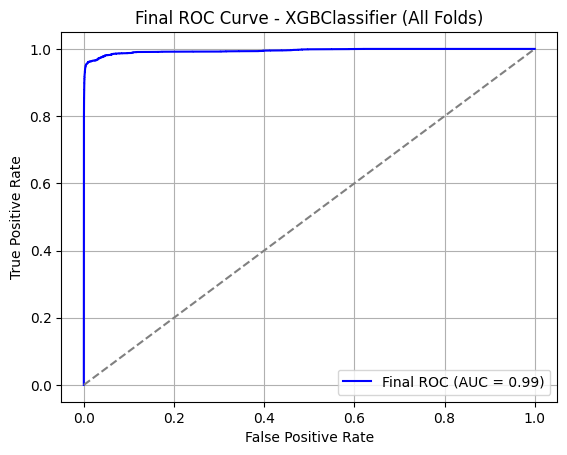

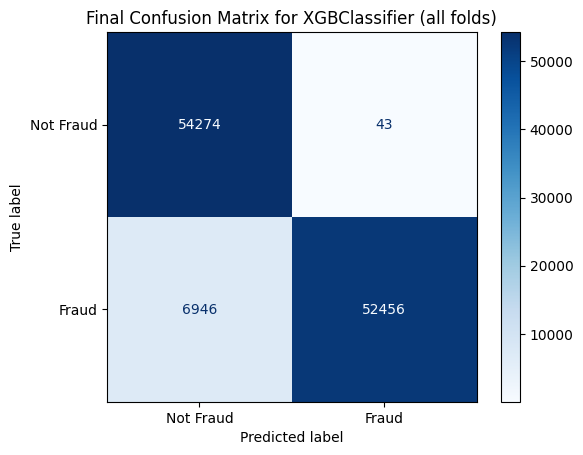



Final Classification Report
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     54317
           1       1.00      0.88      0.94     59402

    accuracy                           0.94    113719
   macro avg       0.94      0.94      0.94    113719
weighted avg       0.95      0.94      0.94    113719



In [475]:
# Running the model
model = xgb.XGBClassifier(n_estimators=200, random_state=42, eval_metric='logloss')
run_temporal_kfold(resampled_df, model)

# Logistic Regression

In [476]:
# Oversampling experiment results can be found at:
# https://docs.google.com/document/d/1VCSaRQPcvjGzVNETezPAWO7yu2Gcmm_5nTvNxtn4vl0/edit?usp=sharing

# Leaving data imbalanced for Logistic Regression
#resampled_df = pd.concat([X, y], axis=1).reset_index(drop=True)
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y)
resampled_df = pd.concat([X_resampled, y_resampled], axis=1).reset_index(drop=True)


Model: LogisticRegression


Classes in Fold 0: {1: 13905, 0: 8839}

Classification Report for Fold - 0
              precision    recall  f1-score   support

           0       0.77      0.94      0.84      8839
           1       0.95      0.82      0.88     13905

    accuracy                           0.86     22744
   macro avg       0.86      0.88      0.86     22744
weighted avg       0.88      0.86      0.87     22744



Classes in Fold 1: {1: 12519, 0: 10226}

Classification Report for Fold - 1
              precision    recall  f1-score   support

           0       0.84      0.91      0.87     10226
           1       0.92      0.86      0.89     12519

    accuracy                           0.88     22745
   macro avg       0.88      0.88      0.88     22745
weighted avg       0.88      0.88      0.88     22745



Classes in Fold 2: {1: 17611, 0: 5134}

Classification Report for Fold - 2
              precision    recall  f1-score   support

           0       0.72      0.8

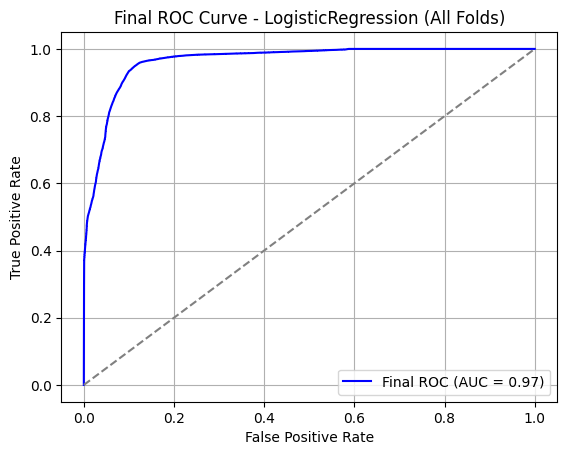

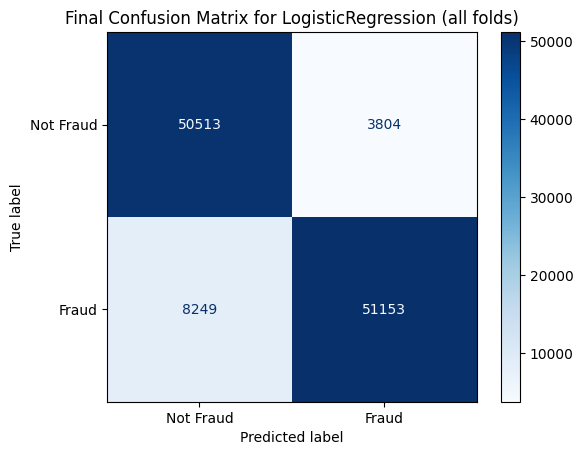



Final Classification Report
              precision    recall  f1-score   support

           0       0.86      0.93      0.89     54317
           1       0.93      0.86      0.89     59402

    accuracy                           0.89    113719
   macro avg       0.90      0.90      0.89    113719
weighted avg       0.90      0.89      0.89    113719



In [477]:
# Running the model
model = LogisticRegression(max_iter=1000)
run_temporal_kfold(resampled_df, model)

# LGBM Classifier

In [478]:
# Oversampling experiment results can be found at:
# https://docs.google.com/document/d/1VCSaRQPcvjGzVNETezPAWO7yu2Gcmm_5nTvNxtn4vl0/edit?usp=sharing

# Using ADASYN for LGBM Classifier
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y)
resampled_df = pd.concat([X_resampled, y_resampled], axis=1).reset_index(drop=True)


Model: LGBMClassifier
[LightGBM] [Info] Number of positive: 41843, number of negative: 49135
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 90978, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.459924 -> initscore=-0.160647
[LightGBM] [Info] Start training from score -0.160647
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

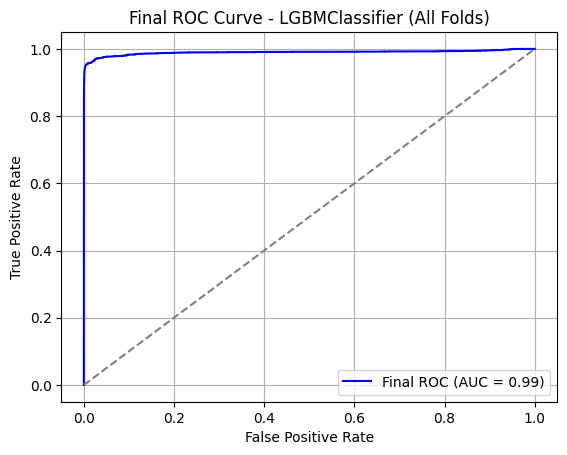

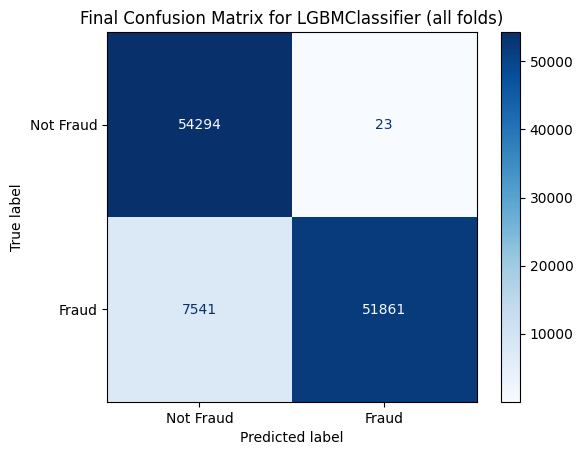



Final Classification Report
              precision    recall  f1-score   support

           0       0.88      1.00      0.93     54317
           1       1.00      0.87      0.93     59402

    accuracy                           0.93    113719
   macro avg       0.94      0.94      0.93    113719
weighted avg       0.94      0.93      0.93    113719



In [479]:
# Running the model

model = lgb.LGBMClassifier(n_estimators=200, random_state=42)
run_temporal_kfold(resampled_df, model)